## Visualizacion de valores faltantes

Ahora grafiquemos para visualizar nuestra variables:

In [17]:
%run 0.4-Codificacion.ipynb
%run pandas-API.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


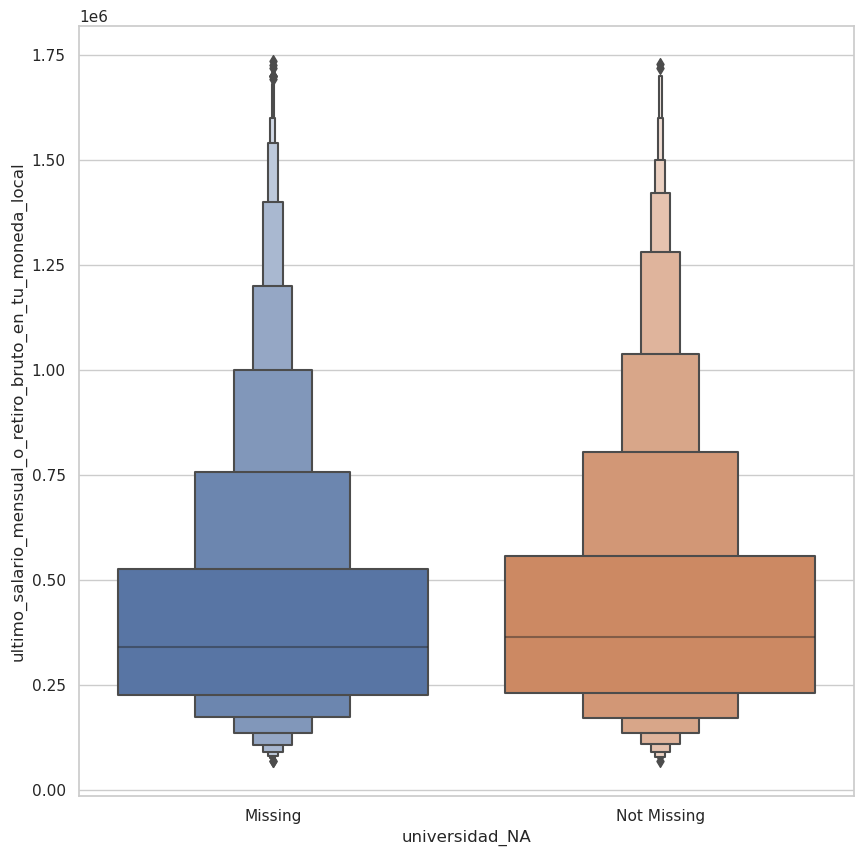

In [2]:
(
    datos_sustituidos
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data= df,
                x='universidad_NA',
                y='ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local'
            )
        )
    )

);

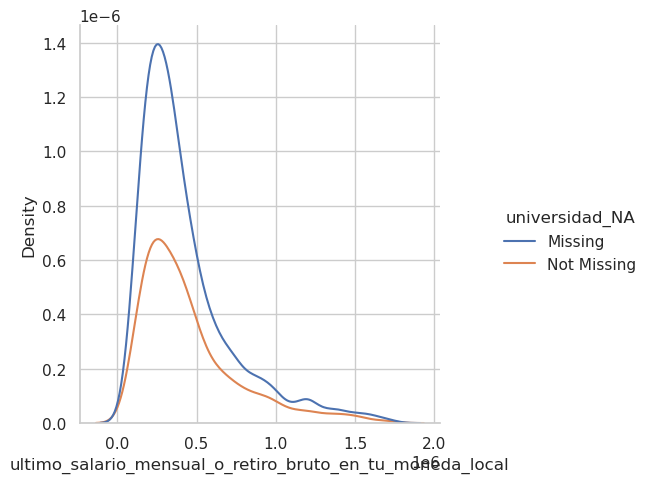

In [3]:
(
    datos_sustituidos
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data= df,
                x='ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local',
                hue='universidad_NA',
                kind='kde'
            )
        )
    )

);

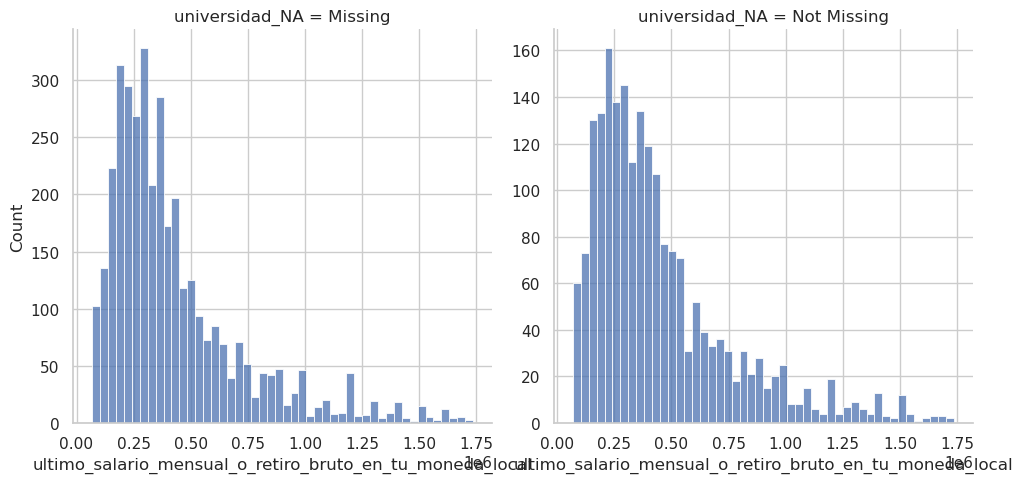

In [4]:
(
    datos_sustituidos
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data= df,
                x='ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local',
                col='universidad_NA',
                facet_kws={
                    'sharey': False
                }
            )
        )
    )

);

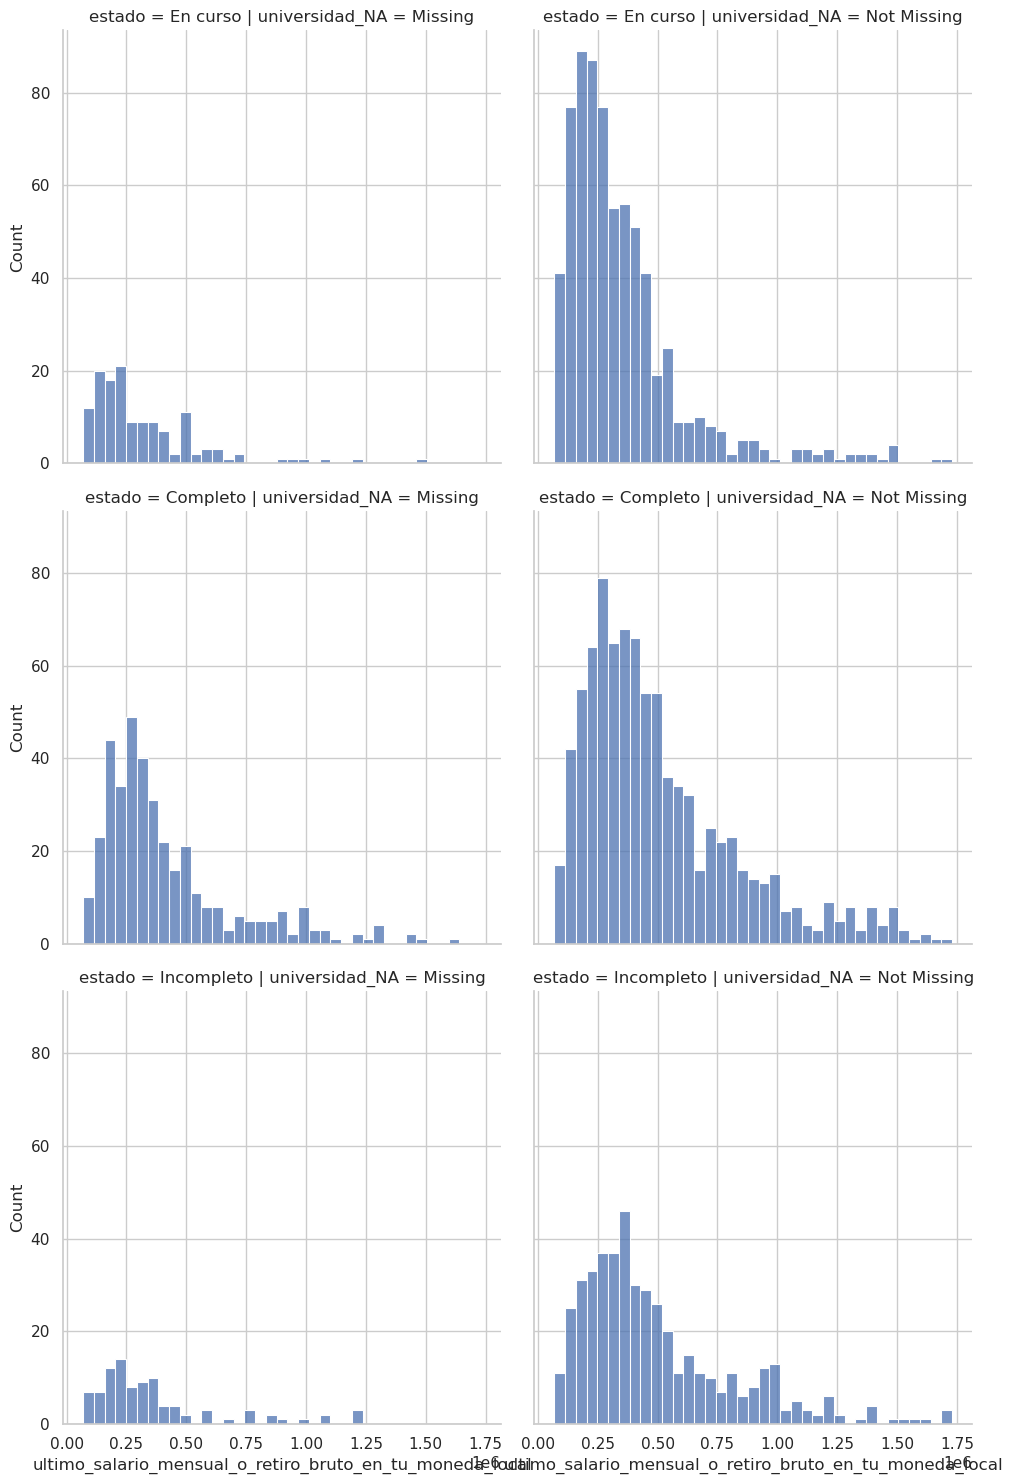

In [5]:
(
    datos_sustituidos
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data= df,
                x='ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local',
                col='universidad_NA',
                row='estado'
            )
        )
    )
);

### Visualizacion de dos variables
Exploremos el concepto con multiples variables, agregamos un valor dummie que nos permite agregar valores random para poder visualizarlo

In [33]:
# funcion que añade valores aleatorios a las variables con valores faltantes
# para visualizarlos en un eje
def column_fill_with_dummies(
    column: pd.Series,#Una serie o un string
    proportion_below: float=0.10, #Proporcion de los datos en la grafica 
    jitter: float=0.075,  # evita el solapamiento de los puntos en la grafica
    seed: int=42, #semilla para la aleatoriedad (42 la respuesta a todo)
) -> pd.Series: # la funcion retorna una serie

    #Copiar las columnas del dataframe
    column = column.copy(deep=True)

    #Extraer los valores de las variables
    missing_mask = column.isna() # matriz de booleanos
    number_missing_values = missing_mask.sum() #conteo de valores faltantes
    column_range = column.max() - column.min() #rango de las variables para que no se solapen

    # shift data
    column_shift = column.min() - column.min() * proportion_below

    # crear un poco de ruido 'jitter' alrededor de los puntos 
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - 2) * column_range * jitter

    #Guardar los nuevos datos aleatorios
    column[missing_mask] = column_shift + column_jitter

    return column

In [34]:
datos_sustituidos.info('object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 50 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   estoy_trabajando_en                                       5764 non-null   object 
 1   donde_estas_trabajando                                    5764 non-null   object 
 2   dedicacion                                                5764 non-null   object 
 3   tipo_de_contrato                                          5764 non-null   object 
 4   ultimo_salario_mensual_o_retiro_bruto_en_tu_moneda_local  5764 non-null   float64
 5   ultimo_salario_mensual_o_retiro_neto_en_tu_moneda_local   5533 non-null   float64
 6   pagos_en_dolares                                          1549 non-null   object 
 7   dolarizado_cual_fue_el_ultimo_valor                       778 non-null    float64
 8   pagos_en_criptomon

In [35]:
def purification_column(datos, variable):
    for indice, valor in datos[variable].items():
        try:
            datos.at[indice, variable] = float(valor)
        except ValueError:
            #print(f"El valor en la fila {indice} no se puede, dice: ",valor)
            datos.at[indice, variable] = np.nan
    datos[variable]= pd.to_numeric(datos[variable], errors='coerce')

In [36]:
# Transformamos columnas de tipo objeto a numericos 
purification_column(datos_sustituidos,'ultimo_salario_mensual_o_retiro_neto_en_tu_moneda_local')
purification_column(datos_sustituidos,'dolarizado_cual_fue_el_ultimo_valor')
purification_column(datos_sustituidos,'cuanto_cobras_por_guardia')
purification_column(datos_sustituidos,'que_porcentaje_o_monto_recibis_en_criptomonedas')


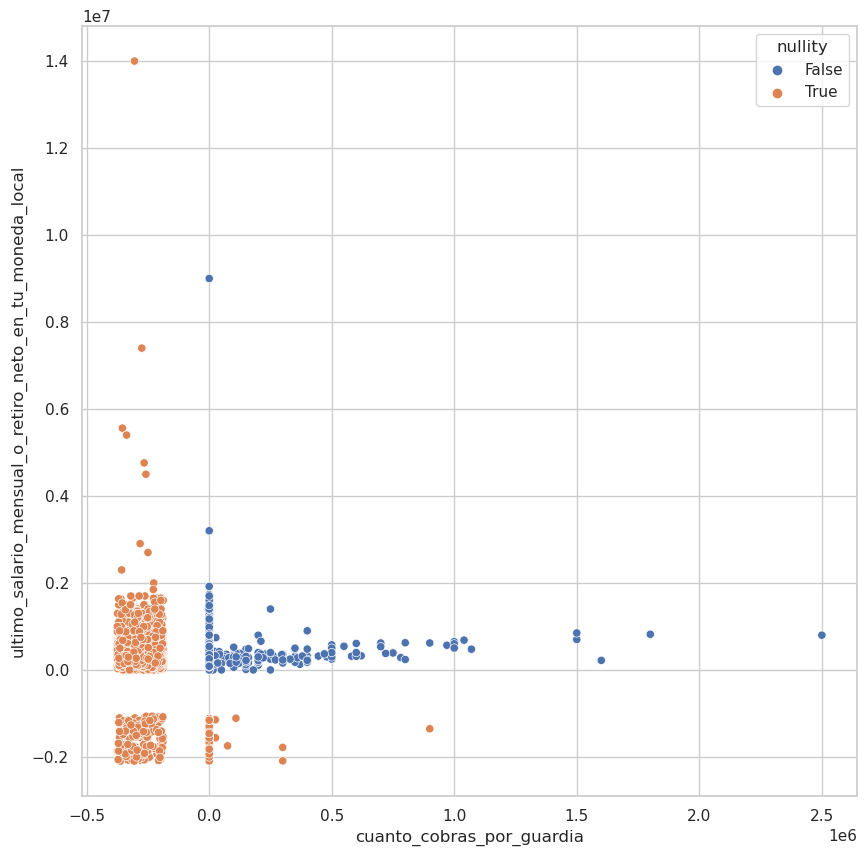

In [37]:
plt.figure(figsize=(10, 10))

(
    datos_sustituidos
    .select_dtypes(
        exclude="object"
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]]
    )
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        lambda column: column if "_NA" in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter=0.075)
    )
    .assign(
        nullity=lambda df: df.cuanto_cobras_por_guardia_NA | df.ultimo_salario_mensual_o_retiro_neto_en_tu_moneda_local_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data=df,
                x="cuanto_cobras_por_guardia",
                y="ultimo_salario_mensual_o_retiro_neto_en_tu_moneda_local",
                hue="nullity"
            )
        )
    )
);

#### Que informacion podria suponer la grafica 🤔 ?